# FMRI Analysis 

In this notebook, we analyze the incongruent-congruent MSIT contrast in the fMRI. To do so we use a standard analysis approach of first fitting an individual GLM to each subject (first levels) and then performing group statistics on these individual subject maps. This is done separately for the left and right cortical surfaces as well as the subcortical volume in a standardized fsaverage space to facilitate comparison across subjects. The goal with this analysis is to spatially localize areas of the brain that are differentially involved in incongruent compared to congruent trials in the MSIT task. 

# First Levels

First levels involves fitting a GLM and computing incongruent-congruent contrast maps for each subject invidually. These maps are then passed to group level statistics. This two step process serves as a computationally feasible approximation to a hierarchical model.

The first level GLM is fit individually for every voxel for each subject. We use a separate regressor for incongruent and congruent trials as well as multiple nuisance regressors. The incongruent and congruent regressors are convolved with a canonical hemodynamic response function (SPM no derivatives) in order to account for the delayed shape of the BOLD response. Additionally, the GLM is corrected for auto-correlated residuals due to the fact that the BOLD response from a previous trial sustains through the presentation of the next trial.

## Make Task Paradigm Files 

Here I make regressors for the congruent and incongruent conditions. I make both full duration boxcar regressors and variable RT epoch regressors to look at RT independent and dependent effects. Methods and considerations based on the following papers:

- Tal Yarkoni's Blog Post on time on task implications: https://www.talyarkoni.org/blog/2010/06/16/time-on-task-effects-in-fmri-research-why-you-should-care/
- Yarkoni paper related to above blog post: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2622763/
- Grinbad Paper explaining variable RT epoch method as most ideal method for accounting for time on task effects: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2654219/

It is especially important to control for RT effects in this task because there is such a large difference in response time between the two conditions. Controlling for RT removes regions of different amplitude where the difference was simply due to longer BOLD accumulation due to the increased response times. See the above references for more information.

In [ ]:
import sys
sys.path.append('../src')
from utils import select_subjects
import pandas as pd

# load and clean behavior
behavior = pd.read_csv('../data/derivatives/behavior/group_data.tsv',
                       sep='\t', na_values='n/a')
behavior = behavior[behavior.modality == 'fmri']
exclusions = ['error', 'post_error', 'no_response', 'fast_rt']
behavior = behavior[behavior[exclusions].sum(axis=1) == 0]

# output directory
fsfast_path = '../data/derivatives/fsfast'

subjects = select_subjects('both')
for subject in subjects:
    
    sub_behavior = behavior[behavior.participant_id == subject]
    sub_behavior['tt'] = sub_behavior.trial_type.astype('category').cat.codes + 1
    sub_behavior['weight'] = 1.0
    
    # extract behavior information
    for typ in ['base', 'rt']:
        if typ == 'base':
            columns = ['onset', 'tt', 'duration', 'weight', 'trial_type']
        else:
            columns = ['onset', 'tt', 'response_time', 'weight', 'trial_type']
        
        df = sub_behavior[columns]
        
        # save the regressors
        f = '%s/%s/msit/001/%s.par'
        df.to_csv(f % (fsfast_path, subject, typ), header=False, sep='\t',
                  index=False)
        
        
print('Done!') 

## Make Motion Timepoint Censors

Controlling for motion is important to ensure that our results are not biased by motion artifacts. We use only functional displacement based motion timepoint censoring (and no motion regressors) as determined in <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3895106/"> Siegel 2013</a>. We use their threshold of 0.9 mm though we recognize this was not a global recommendation, but it is used here as a reasonable value without further investigation. 

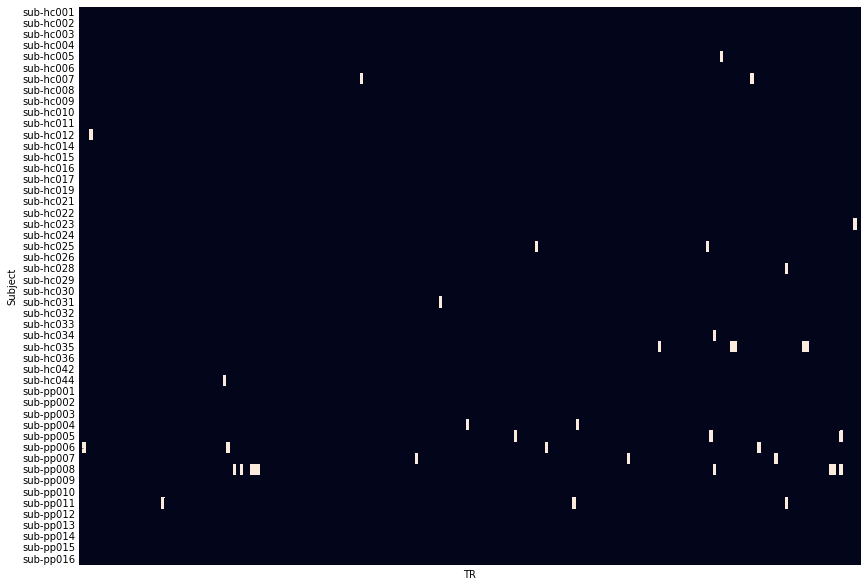

In [2]:
import sys
sys.path.append('../src')
from utils import select_subjects
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

fd = 0.9

fmriprep_path = '../data/derivatives/fmriprep'
fsfast_path = '../data/derivatives/fsfast'

subjects = select_subjects('both')
fds = []
for i, subject in enumerate(subjects):
    
    f = '%s/%s/func/%s_task-msit_bold_confounds.tsv'
    confounds = pd.read_csv(f % (fmriprep_path, subject, subject),
                            sep='\t', na_values='n/a')
    
    # determine fd censor indices 
    fd_ix = np.array(confounds.FramewiseDisplacement >= fd).astype(int)
    fds.append(fd_ix)
    
    # save censor indices
    f = '%s/%s/msit/001/fd_censor.par' 
    np.savetxt(f % (fsfast_path, subject), fd_ix, fmt='%d')
        
# Plot censor heatmap
fds = np.array(fds)
plt.figure(figsize=(14, 10))
sns.heatmap(fds, cbar=False)
plt.xticks(())
plt.yticks(np.arange(len(subjects)) + .5, subjects, rotation=0)
plt.xlabel('TR')
plt.ylabel('Subject')
plt.show()

## Run 1st Levels

The following cells actually run the first level GLMs. To do so, we make use of Freesurfer's <a href="https://surfer.nmr.mgh.harvard.edu/fswiki/FsFast">fsfast fMRI analysis package</a>.


### Set up the analysis

This cell configures the analysis. It does many things including determining the space to do the analysis in, the form of the hemodynamic response kernel that will be convolved with the design matrix, and what additional nuiscance regressors to add to the design matrix.

In [ ]:
%%bash

# Source freesurfer v6
export FREESURFER_HOME=/usr/local/freesurfer/stable6_0_0
. /usr/local/freesurfer/stable6_0_0/SetUpFreeSurfer.sh
export SUBJECTS_DIR=/autofs/space/cassia_001/users/matt/msit/data/derivatives/freesurfer

# get into fsfast directory
export FSFAST=../data/derivatives/fsfast
cd $FSFAST

# set up the analyses
types="base rt"
hemis="lh rh"
fwhm=4

for type in $types
do
    for hemi in $hemis 
    do
        mkanalysis-sess -analysis $type.$hemi \
                        -surface fsaverage $hemi \
                        -event-related \
                        -fsd msit \
                        -fwhm $fwhm \
                        -per-run \
                        -TR 1.75 \
                        -refeventdur 1.75 \
                        -paradigm $type.par \
                        -nconditions 2 \
                        -spmhrf 0 \
                        -polyfit 0 \
                        -hpf 0.01 \
                        -nskip 4 \
                        -tpexclude fd_censor.par \
                        -no-mask \
                        -force
    done
    
    mkanalysis-sess -analysis $type.mni305 \
                    -mni305 \
                    -event-related \
                    -fsd msit \
                    -fwhm $fwhm \
                    -per-run \
                    -TR 1.75 \
                    -refeventdur 1.75 \
                    -paradigm $type.par \
                    -nconditions 2 \
                    -spmhrf 0 \
                    -polyfit 0 \
                    -hpf 0.01 \
                    -nskip 4 \
                    -tpexclude fd_censor.par \
                    -force
done

### Compute Contrast Matrices

This cell pre-computes the incongruent-congruent contrast matrices that we will use to get the contrast estimate from the GLM.

In [ ]:
%%bash

# Source freesurfer v6
export FREESURFER_HOME=/usr/local/freesurfer/stable6_0_0
. /usr/local/freesurfer/stable6_0_0/SetUpFreeSurfer.sh
export SUBJECTS_DIR=/autofs/space/cassia_001/users/matt/msit/data/derivatives/freesurfer

# get into fsfast directory
export FSFAST=../data/derivatives/fsfast
cd $FSFAST

types="base rt"
spaces="lh rh mni305"

for type in $types
do
    for space in $spaces
    do
        mkcontrast-sess -analysis $type.$space \
                        -contrast incongruent \
                        -a 2
                        
        mkcontrast-sess -analysis $type.$space \
                        -contrast congruent \
                        -a 1
                        
        mkcontrast-sess -analysis $type.$space\
                        -contrast incongruent-congruent \
                        -a 2 -c 1
                        
    done
    
done

### Fit the GLMs

This cell actually fits the GLM for each subject.

In [ ]:
%%bash

# Source freesurfer v6
export FREESURFER_HOME=/usr/local/freesurfer/stable6_0_0
. /usr/local/freesurfer/stable6_0_0/SetUpFreeSurfer.sh
export SUBJECTS_DIR=/autofs/space/cassia_001/users/matt/msit/data/derivatives/freesurfer

# get into fsfast directory
export FSFAST=../data/derivatives/fsfast
cd $FSFAST

# set up the analyses
types="base rt"
spaces="lh rh mni305"

for type in $types
do
    for space in $spaces
    do
        selxavg3-sess -analysis $type.$space -sf subjects -no-preproc \
                      -overwrite
    done
    
done

### Visualize the Design Matrices

This cell produces a summary plot of each subject's design matrix. The design matrix only gets saved out after the GLM fit command which is why we visualize after fitting.

Our design matrix consists of the following regressors:
- incongruent and congruent response times convolved with the BOLD HRF function
- two highpass filter nuisance regressors to account for scanner drift and other low frequency artifacts
- four censor nuisance regressors to exclude the first 4 acquisitions to account for the scanner settling
- any additional motion nuisance censor regressors that exceed the 0.9 mm threshold

This cell produces a separate plot for both the RT-controlled and non-RT-controlled design matrix including:
- a heatmap of the design matrix
- plots of the incongruent and congruent response times convolved with the HRF kernel
- Plots of the highpass filter nuiscance regressors to account for scanner drift and other low frequency artifacts
- A barplot of the variance inflation factor (VIF) scores for each regressor. The VIF is a measure of the collinearity of a regressor with the other regressors. We want these scores to prevent issues with fitting the GLM.

In [6]:
import sys
sys.path.append('../src')
from utils import select_subjects
from fmri import plot_design_matrix
import matplotlib.pyplot as plt

fsfast_path = '../data/derivatives/fsfast'

subjects = select_subjects('both')
for subject in subjects:

    for typ in ['base', 'rt']:
        
        fig = plot_design_matrix(fsfast_path, subject, typ)
        f = '%s/%s/msit/%s_design_matrix.png'
        fig.savefig(f % (fsfast_path, subject, typ))
        plt.close(fig)
        
print('Done!')

Done!


## Visualize 1st Level Results

The following cell will create significance maps for the first level incongruent-congruent contrast maps for each subject.

In [ ]:
from surfer import Brain
import sys
sys.path.append('../src')
from utils import select_subjects

fsfast_path = '../data/derivatives/fsfast'
SUBJECTS_DIR = '/autofs/space/cassia_001/users/matt/msit/data/derivatives/freesurfer'

subjects = select_subjects('both')
for subject in subjects:

    for typ in ['base', 'rt']:
        
        # plot sig
        brain = Brain('fsaverage', 'split', 'inflated', views=['lat', 'med'],
                      subjects_dir=SUBJECTS_DIR)
        
        for hemi in ['lh', 'rh']:
            f = '%s/%s/msit/%s.%s/incongruent-congruent/sig.nii.gz' % (fsfast_path, subject,
                                                 typ, hemi)
            brain.add_overlay(f, hemi=hemi, min=1.3, max=5)
        f = '%s/%s/msit/%s_sig.png' % (fsfast_path, subject, typ) 
        brain.save_image(f)

print('Done!')

# Group Levels

The next stage is to find spatial clusters where there is a significant difference between the incongruent and congruent conditions across subjects. To do so, we compute a GLM over the first level contrast maps from each subject. 

## Collect Data & Compute Connectivity

This is a convenience cell that collects all of the needed data for the statistics into a single file. This includes:
- fMRI first levels maps: We collect the incongruent - congruent contrast effect sizes from each subject for each voxel to get a # subjects x # voxels data array (Y).
- Design matrix: We are simply interested in whether the contrast estimates are different from 0. This could be done with a simple t-test. However, our subjects were collected across multiple different scanners so we include this as a nuisance regressor (technically regressors using one hot encoding). This gives us a # subjects x 3 array (X, 3 = intercept + 2 scanner type nuisance regressors).
- Weight matrix: We collect the inverse contrast effect variances to be used as weights for a weighted GLM. This gives us a # subjects x # voxels array (W)
- Permuted sign flips: We pre-compute the sign flip permutations (sign flipping is equivalent to permuting the incongruent and congruent labels in random subsets of the subjects). This provides a # permutations x # subjects matrix
- Connectivity matrix: A sparse matrix containing the connected vertices and voxels for the given space.
- Include: A boolean mask denoting which voxels had non-zero variance across subjects

These all get saved in a compressed numpy file separately for each space and design type.

In [ ]:
import sys
sys.path.append('../src')
from utils import select_subjects
from fmri import compute_connectivity
import numpy as np
import nibabel as nib
import os
import pandas as pd

deriv_dir = '../data/derivatives/fmri_group_levels'
if not os.path.exists(deriv_dir):
    os.makedirs(deriv_dir)

with open('experiment_config.json', 'r') as fid:
    config = json.load(fid)
typs = config['fmri_types']
spaces = config['fmri_spaces']

np.random.seed(10)

subjects = select_subjects('both')
fsfast_dir = '../data/derivatives/fsfast'
subjects_dir = '../data/derivatives/freesurfer'

# create scanner type nuisance regressors
demo = pd.read_csv('../data/participants.tsv', sep='\t', na_values='n/a')
demo = demo[demo.participant_id.isin(subjects)]
sc = demo.scanner.astype('category').cat.codes
Z = np.array(pd.get_dummies(sc))[:, 1:]

# compute the subcortical mask
tmp = config['subcort_roi']
roi_dict = dict()
for key in tmp:
    roi_dict[int(key)] = tmp[key]
aseg = '%s/fsaverage/mri.2mm/aseg.mgz' % subjects_dir
aseg = nib.load(aseg).get_data()
subcort_mask = np.in1d(aseg, roi_dict.keys()).reshape(aseg.shape)
voxels = np.vstack(np.where(subcort_mask)).T
print(voxels.shape)

for typ in typs:
    print(typ)
    
    for space in spaces:
        print(space)
        
        # compute connectivity
        coo = compute_connectivity(space, subjects_dir, voxels)
        
        # load data + weights
        Ws = []
        Ys = []
        for subject in subjects:
            analysis_folder = '%s/%s/msit/%s.%s/incongruent-congruent'
            analysis_folder = analysis_folder % (fsfast_dir, subject,
                                                 typ, space)
            
            f = '%s/ces.nii.gz' % analysis_folder
            Ys.append(nib.load(f).get_data())
            
            f = '%s/cesvar.nii.gz' % analysis_folder
            Ws.append(nib.load(f).get_data())
            
        # weights = inverse variance
        W = np.array(Ws).squeeze()
        W = np.abs(1 / W)
        Y = np.array(Ys).squeeze()
        
        # 1d the subcortical data and reduce to rois
        if space == 'mni305':
            W = W[:, subcort_mask]
            Y = Y[:, subcort_mask]
        
        # only include voxels that had non-zero variance for every subject
        include = ~np.isinf(W).sum(axis=0).astype(bool)
        
        # compute sign flips 
        sign_flips = np.random.choice([1, -1], 
                                      size=(config['num_fmri_perm'], 
                                            Y.shape[0]),
                                      replace=True)
        
        np.savez_compressed('%s/%s_%s_data.npz' % (deriv_dir, typ, space),
                            Y=Y, W=W, Z=Z, sign_flips=sign_flips,
                            include=include, conn=coo.data, col=coo.col,
                            shape=coo.shape, row=coo.row, 
                            subcort_mask=subcort_mask, voxel_ix=voxels)
print('Done!') 

## Compute TFCE Permutation P-Values

Here we actually compute the group statistics. We use a relatively new and robust technique known as <a href="https://www.ncbi.nlm.nih.gov/pubmed/18501637"> threshold free cluster enhancement (TFCE)</a>. TFCE is an improvement over spatial cluster permutation testing. It works by first scaling the image to enhance spatially contiguous clusters. One then does their permutations using this TFCE enhanced map rather than the original. So the algorithm becomes:

1. Compute the WLS F-statistic for the intercept testing whether the contrast effect is different from 0 separately for each voxel/vertex
2. TFCE enhance the F-statistic map
3. Permute the data.  In our case, since we are looking at a simple within subjects two condition contrast, this is equivalent to doing sign flips on random subsets of the subject's contrast effect size estimates. We also ensure to <a href="https://www.sciencedirect.com/science/article/pii/S1053811914000913"> control for nuisance regressors by sign flipping just the residuals after the nuisance regressors estimates have been subtracted out</a>.
4. Compute the WLS F-statistic and TFCE enhance the permuted data. Select out the maximum TFCE value across all voxels to correct for the vast number of tests across voxels.
5. Repeat 3 and 4 1000 times to build a permutation null distribution.
6. Compute the p-value at each voxel as the fraction of permuted max TFCE values whose absolute magnitude are larger than the TFCE value at each voxel in the unpermuted data.

In [ ]:
import sys
sys.path.append('../src')
from fmri import wls
import nibabel as nib
import os
os.environ['OMP_NUM_THREADS'] = '1'
import numpy as np
import pandas as pd
from mne.stats.cluster_level import _find_clusters
import statsmodels.api as sm
from mne import set_log_level
from joblib import Parallel, delayed
from scipy.sparse import coo_matrix
import json

set_log_level('critical')

def perm_tfce_glm(i):
    """
    Computes and returns the maximum threshold free cluster enhanced
    fmap value for a randomly permuted sample of the data. Serves as a 
    wrapper for joblib parallelize by making use of other globally defined
    variables in the cell.

    Parameters
    ----------
    i: int 
        The permutation index

    Returns
    -------
    float
        The maximum tfce f value for the given permutation
    """
    print(i)
    
    sf = sign_flips[i, :]
    fs = []
    for j in range(Y.shape[1]):
        if include[j]:
            Z = X[:, 1:]
            w = np.diag(W[:, j])
            
            # permute only the residuals
            y = Y[:, j][:, np.newaxis]
            ZZ = Z.dot(np.linalg.inv(Z.T.dot(w).dot(Z))).dot(Z.T).dot(w)
            Rz = np.identity(Y.shape[0]) - ZZ
            y_perm = np.diag(sf).dot(Rz).dot(y)
            
            # compute wls f-statistic
            beta, f = wls(X, y_perm, w)
            fs.append(f[0])
            
        else:
            fs.append(0)
    fs = np.array(fs)
    
    # compute tfce
    _, tfce = _find_clusters(fs, threshold, tail=0, 
                             connectivity=coo, include=include,
                             max_step=1, show_info=False)
    
    return np.max(np.abs(tfce))

with open('experiment_config.json', 'r') as fid:
    config = json.load(fid)
typs = config['fmri_types']
spaces = config['fmri_spaces']

deriv_dir = '../data/derivatives/fmri_group_levels'
subjects_dir = '../data/derivatives/freesurfer/fsaverage'
np.random.seed(10)

for typ in typs:
    print(typ)
    
    for space in spaces:
        print(space)
        
        # extract data
        data = np.load('%s/%s_%s_data.npz' % (deriv_dir, typ, space))
        Z = data['Z']
        X = np.hstack((np.ones((Z.shape[0], 1)), Z))
        W = data['W']
        Y = data['Y']
        sign_flips = data['sign_flips']
        include = data['include']
        num_perm = sign_flips.shape[0]
        
        # extract connectivity 
        coo = coo_matrix((data['conn'], (data['row'], data['col'])),
                          data['shape'])
            
        # compute the un-permuted fmap 
        betas = []
        fs = []
        for i in range(Y.shape[1]):
            if include[i]:
                beta, f = wls(X, Y[:, i][:, np.newaxis],
                              np.diag(W[:, i]))
                fs.append(f[0])
                betas.append(beta[0])
            else:
                fs.append(0)
                betas.append(0)
        betas = np.array(betas)
        fs = np.array(fs)
            
        # threshold fre cluster enhance the un-permuted fmap
        _, tfce = _find_clusters(fs, threshold, tail=0, 
                                 connectivity=coo, include=include,
                                 max_step=1, show_info=False)
        
        # compute permuted tfce maps in parallel
        perm_dist = Parallel(n_jobs=10)(delayed(perm_tfce_glm)(i) 
                                       for i in range(num_perm))
        perm_dist = np.array(perm_dist)
        
        # compute the permutation p-values
        tmp = np.tile(perm_dist[:, np.newaxis], (1, tfce.shape[0])) 
        p = (np.sum(np.abs(tmp) >= np.abs(tfce), 
                    axis=0) + 1.) / (num_perm + 1.)
        
        np.savez_compressed('%s/%s_%s_stats.npz' % (deriv_dir, typ, space),
                            pvals=p, perm_dist=perm_dist, beta=betas,
                            fmap=fs, tfce=tfce, include=include)
        
print('Done!')

## Screen Clusters & Save Maps

In this cell, we take the computed p-values and effect sizes and convert them into nifti brain maps that can then be visualized. Additionally we screen out spurious clusters that are smaller than pre-defined cluster sizes (100 mm^2 for the surface data and 20 voxels for the subcortical areas).

In [5]:
import nibabel as nib
import numpy as np
import json
from mne.stats.cluster_level import _find_clusters as find_clusters
from mne import read_surface, spatial_tris_connectivity 
from scipy.sparse import coo_matrix

deriv_dir = '../data/derivatives/fmri_group_levels'
fsfast_dir = '../data/derivatives/fsfast'
subjects_dir = '../data/derivatives/freesurfer'
np.random.seed(10)

with open('experiment_config.json', 'r') as fid:
    config = json.load(fid)
typs = config['fmri_types']
spaces = config['fmri_spaces']

for typ in typs:
    print(typ)
    
    for space in spaces:
        print(space)
        
        stats = np.load('%s/%s_%s_stats.npz' % (deriv_dir, typ, space))
        stats = {'pvals': stats['pvals'],
                 'tfce': stats['tfce'],
                 'beta': stats['beta'],
                 'include': stats['include'],
                 'perm_dist': stats['perm_dist']}
        
        # log transform and sign the p-values
        stats['pvals'] = -np.log10(stats['pvals']) * np.sign(stats['beta'])
        stats['tfce'] = stats['tfce'] * np.sign(stats['beta'])
        
        # load connectivity
        data = np.load('%s/%s_%s_data.npz' % (deriv_dir, typ, space))
        coo = coo_matrix((data['conn'], (data['row'], data['col'])),
                         data['shape'])
        
        # extract clusters
        threshold = -np.log10(0.05)
        clusters, sums = find_clusters(stats['pvals'].squeeze(), threshold, 
                                       tail=0, connectivity=coo, 
                                       include=stats['include'],
                                       t_power=0)
        
        # compute mm cluster size for cortical surface
        if space != 'mni305':
            f = '%s/fsaverage/surf/%s.white.avg.area.mgh'
            avg_area = nib.load(f % (subjects_dir, space)).get_data().squeeze()
            sums = np.array([avg_area[c].sum() for c in clusters])
        
        
        # threshold clusters by size
        stats['mask'] = np.zeros_like(stats['pvals'])
        min_cluster = {'lh': 100, 'rh': 100, 'mni305': 20}
        good_ix = []
        new_clusters = []
        new_sums = []
        for c, s in zip(clusters, sums):
            if s > min_cluster[space]:
                new_clusters.append(c)
                new_sums.append(s)
                good_ix.append(c)
        print('%d clusters found' % len(good_ix))
        if len(good_ix) > 0:
            good_ix = np.concatenate(good_ix)
            stats['mask'][good_ix] = 1
        
        
        # reshape and save maps
        for mapp in ['pvals', 'beta', 'tfce']:
            stats[mapp] *= stats['mask']
            if space == 'mni305':
                aseg = '%s/fsaverage/mri.2mm/aseg.mgz' % subjects_dir
                aseg = nib.load(aseg)
                affine = aseg.affine
                voxel_ix = data['voxel_ix']
                mapp_data = np.zeros(aseg.get_data().shape)
                x, y, z = voxel_ix[:, 0], voxel_ix[:, 1], voxel_ix[:, 2]
                mapp_data[x, y, z] += stats[mapp].astype(float)
            else:
                f = '%s/sub-hc005/msit/%s.%s/incongruent-congruent/ces.nii.gz'
                holder = nib.load(f % (fsfast_dir, typ, space))
                affine = holder.affine
                mapp_data = stats[mapp].astype(float)
                
            # extend to full range
            for i in range(4 - len(mapp_data.shape)):
                mapp_data = np.expand_dims(mapp_data, -1)
                
            img = nib.Nifti1Image(mapp_data, affine)
            nib.save(img, '%s/%s_%s_%s.nii' % (deriv_dir, typ, space, mapp))
        
        # save out clusters + cluster mask
        np.savez_compressed('%s/%s_%s_clusters.npz' % (deriv_dir, typ, space),
                            clusters=new_clusters, sums=new_sums,
                            cluster_ix=good_ix)
        
print('Done!') 

base
lh
1 clusters found
rh
5 clusters found
mni305
0 clusters found
rt
lh
2 clusters found
rh
4 clusters found
mni305
0 clusters found
Done!


## Visualize Results

### Cortical Results

We use <a href="https://pysurfer.github.io/"> pysurfer</a> to visualize the results on the cortical surface. The cell below will plot the effect size estimates and the significance values (-log10(p-values)) on the inflated cortical surface for each hemisphere. They are thresholded at a p < .05 value.

In [8]:
from surfer import Brain
import json 

subjects_dir = '../data/derivatives/freesurfer'
deriv_dir = '../data/derivatives/fmri_group_levels'

with open('experiment_config.json', 'r') as fid:
    config = json.load(fid)
typs = config['fmri_types']
spaces = config['fmri_spaces']

for typ in typs:
    for space in spaces[:2]:
        for mapp in ['pvals', 'beta']:
            
            brain = Brain('fsaverage', space, surf, 
                          subjects_dir=subjects_dir, views=['lat', 'med'])
            
            if mapp == 'pvals':
                mi = -np.log10(.05)
                ma = 3 * mi
            else:
                mi, ma = 0.0001, 0.5
                
            overlay = '%s/%s_%s_%s.nii' % (deriv_dir, typ, space, mapp)
            brain.add_overlay(overlay, min=mi, max=ma)

            brain.save_image('%s/%s_%s_%s.png' % (deriv_dir, typ, 
                                                  space, mapp))

### Subcortical Results

The following bash cell uses freesurfer to load the subcortical maps over the fsaverage MRI in freeview.

In [12]:
%%bash

# Source freesurfer v6
export FREESURFER_HOME=/usr/local/freesurfer/stable6_0_0
. /usr/local/freesurfer/stable6_0_0/SetUpFreeSurfer.sh
export SUBJECTS_DIR=/autofs/space/cassia_001/users/matt/msit/data/derivatives/freesurfer

# base or rt
typ=rt
# beta or pvals
map=pvals

cd ../data/derivatives/fmri_group_levels

tkmeditfv fsaverage orig.mgz -aseg -overlay ${typ}_mni305_${map}.nii

Process is interrupted.


# Summary of Results

## Cortical

We generally see consistent results with the <a href="https://www.nature.com/articles/nprot.2006.48"> original MSIT validation paper</a>. This includes the dACC (only left hemisphere), the DLPFC, VLPFC, and Superior Parietal. Additionally, we also see incredibly robust and widespread visual/parietal cortex activation.

Two major trends stand out as well:
- We see much more activation in the left hemsiphere
- The RT-controlled activation is as widespread, if not more so, than the non-RT controlled activation. This is very counterinuitive and a bit of a cause for concern (see issues section below).

## Sub-Cortical

We don't see any significant clusters... I am not sure if this is due to issues with the approach or just a facet of MSIT. My concerns about the global TFCE approach below may be relevant here as well.

## Concerns

1. The RT-controlled activation should be more restricted than the non-RT controlled activation. Seeing almost the opposite is alarming and suggests that something is not quite right.
2. The size and magnitude of the visual activation may be disrupting TFCE. TFCE is sensitive to the cluster size. This large visual cluster could be swamping out the smaller clusters. In fact, it looks as if all of our regions are often being lumped into a single connected cluster which allows them to survive (they get extra magnified in the TFCE due to the size of this cluster). This could also explain why the RT-control doesn't actually reduce the activation very much. Two options for alleviating this could be to split TFCE up into separate larger ROI's. One could also try starting the enhancement at a higher level to prevent bridging. This may just drown out the frontal regions however.
3. No subcortical activation. Not sure if this is due to a design flaw or reasonable.

I would hesitate to interpret these results further without investigating and alleviating the concerns above. Encouragingly, we do see the expected regions showing up on the cortex, which suggests the core statistical approach is likely right. The TFCE process may just need appropriate tweaking.

## Potential Future Directions

- Correct the TFCE method or figure out a more appropriate ROI approach. 
- Look at correlations with different RT model parameters (drift rate, decision boundary, etc.)
- Use fmri spatial localization to seed EEG source space analyses and compare with source space EEG.
- See if fmri spatial cluster activation predicts psychiatric dysfunction or questionnaires related to the task (cognitive flexibility, impulsivity).